In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
get_ipython().magic(u'matplotlib inline')

version = 0.1

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

df.head(5)

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.groupby("Cabin")['Survived']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df.apply(lambda x: x.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# it seems that PassengerId, Name, Ticket, Cabin aren't very useful, drop them for now
df.drop(['PassengerId','Name','Ticket','Cabin'], inplace=True, axis=1)

In [6]:
df.describe()

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10eabed90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ed6b710>]], dtype=object)

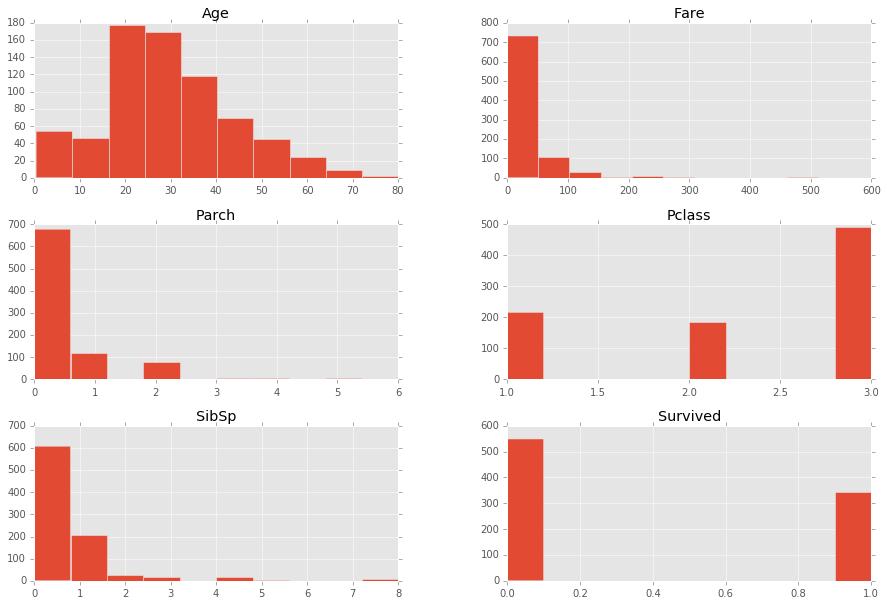

In [7]:
# there are some missing values in Age. But first check the distribution with histogram
df.hist(figsize=(15,10
                ))

In [8]:
# df.plot(kind='box', return_type='dict' , subplots = True, figsize=(15,5))

In [9]:
# fill the missing values in Age
median_age = df.Age.median()
df['Age'].fillna(median_age, inplace = True)

In [10]:
df.apply(lambda x: x.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [11]:
df[df.Embarked.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [12]:
# check Embarked values
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

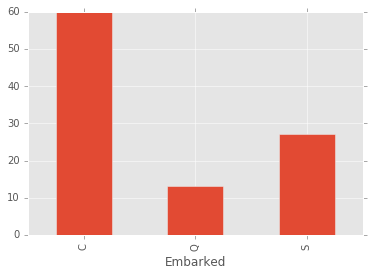

In [13]:
df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [14]:
# it seems that based on Fare-Embarked relation, the missing values are likely C.
df.Embarked.fillna('C', inplace=True)

In [15]:
df.Embarked = df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [16]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [17]:
df['FamilySize'] = df.SibSp + df.Parch
df.drop(['SibSp','Parch'],axis=1, inplace=True)

In [18]:
df['Person'] = df[['Age','Sex']].apply(lambda x: 'child' if x[0]<16 else x[1], axis=1)
# first convert to str, then map
df.Person = df.Person.astype(str).map({'male':1,'female':0,'child':2})
df.drop(['Sex','Age'], axis=1, inplace = True)

In [19]:
df.columns

Index([u'Survived', u'Pclass', u'Fare', u'Embarked', u'FamilySize', u'Person'], dtype='object')

In [20]:
predictor_var = list(df.columns[1:]) ;predictor_var
outcome_var = 'Survived'

In [21]:
categorical = ['Pclass', 'Person','Embarked']
non_categorical = [ i for i in predictor_var if i not in categorical ]

In [22]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = ohe.fit_transform(df[categorical])

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_non_cat = sc.fit_transform(df[non_categorical])

In [24]:
from numpy import hstack
X = hstack((X_non_cat, X_cat))
y = df[outcome_var]
X.shape, X_non_cat.shape, X_cat.shape

((891, 11), (891, 2), (891, 9))

In [25]:
# now let's pick some models to predict loan status

#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics


#Generic function for making a classification model and accessing performance:
def classification_model(model, X, y, cv=10):
  #Fit the model:
  model.fit(X,y)
  
  #Make predictions on training set:
  predictions = model.predict(X)
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,y)
  print "Accuracy : %s" % "{0:.3%}".format(accuracy)

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(X.shape[0], n_folds=cv)
  error = []
  for train, test in kf:
    # Filter training data
    #train_predictors = (X.iloc[train,:])
    # sparse matrix need call tocsc before indexing.
    #train_predictors = X.tocsc()[train,:]
    train_predictors = (X[train,:])
    
    # The target we're using to train the algorithm.
    train_target = y.iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    #error.append(model.score(X.iloc[test,:], y.iloc[test]))
    #error.append(model.score(X.tocsc()[test,:], y.iloc[test]))
    error.append(model.score(X[test,:], y.iloc[test]))
 
  print "Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error))

  #Fit the model again so that it can be refered outside the function:
  model.fit(X,y)

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
from sklearn.model_selection import learning_curve
# http://scikit-learn.org/stable/modules/generated\
#/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [27]:
lr_model = LogisticRegression()
classification_model(lr_model, X, y)

Accuracy : 82.492%
Cross-Validation Score : 81.931%


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

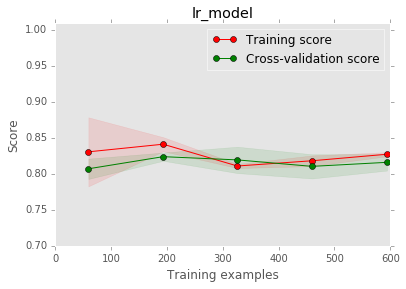

In [28]:
plot_learning_curve(lr_model, "lr_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [29]:
dt_model = DecisionTreeClassifier(max_depth=4)
classification_model(dt_model, X,y)
print dt_model.tree_.node_count

Accuracy : 83.951%
Cross-Validation Score : 82.829%
29


In [30]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=6)
classification_model(rf_model, X,y)

Accuracy : 86.083%
Cross-Validation Score : 82.385%


In [31]:
rf_model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

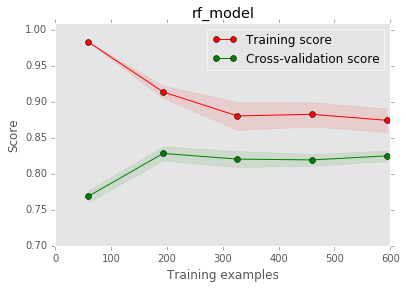

In [32]:
plot_learning_curve(rf_model, "rf_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [33]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', random_state=0, gamma=0.10, C=1)
classification_model(svm_model, X,y)

Accuracy : 83.277%
Cross-Validation Score : 83.280%


In [34]:
svm_model.get_params()

{'C': 1,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

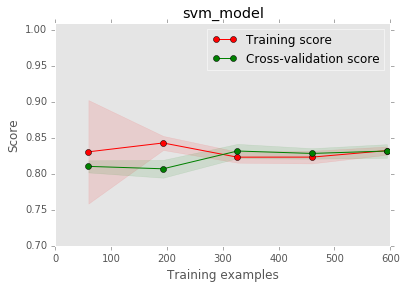

In [35]:
plot_learning_curve(svm_model, "svm_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [36]:
"""
from sklearn.grid_search import GridSearchCV   #Perforing grid search

param_test1 = {
    #'C':(1e-5,1e-2,1,10), C=1, .826
    #'gamma':(.9,.6,.3,.1), gamma = .1
}

gsearch1 = GridSearchCV(estimator = svm.SVC(kernel='rbf', random_state=0, gamma=.1), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch1.fit(X, y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
"""

"\nfrom sklearn.grid_search import GridSearchCV   #Perforing grid search\n\nparam_test1 = {\n    #'C':(1e-5,1e-2,1,10), C=1, .826\n    #'gamma':(.9,.6,.3,.1), gamma = .1\n}\n\ngsearch1 = GridSearchCV(estimator = svm.SVC(kernel='rbf', random_state=0, gamma=.1), \n param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)\n\ngsearch1.fit(X, y)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_\n"

[0]	train-error:0.262078	test-error:0.310113
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 10 rounds.
[1]	train-error:0.15955	test-error:0.198876
[2]	train-error:0.152809	test-error:0.186517
[3]	train-error:0.147472	test-error:0.186517
[4]	train-error:0.148033	test-error:0.18764
[5]	train-error:0.142696	test-error:0.177528
[6]	train-error:0.143258	test-error:0.174157
[7]	train-error:0.139606	test-error:0.178651
[8]	train-error:0.141573	test-error:0.176404
[9]	train-error:0.141292	test-error:0.176404
[10]	train-error:0.141292	test-error:0.174157
[11]	train-error:0.14073	test-error:0.176404
[12]	train-error:0.140168	test-error:0.176404
[13]	train-error:0.139888	test-error:0.174157
[14]	train-error:0.139607	test-error:0.180899
[15]	train-error:0.138483	test-error:0.176404
[16]	train-error:0.139045	test-error:0.177528
Stopping. Best iteration:
[6]	train-error:0.143258+0.00710615	test-error:0.174157+0.01

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 10 rounds.
[1]	train-error:0.166573	test-error:0.191011
[2]	train-error:0.160393	test-error:0.183146
[3]	train-error:0.157303	test-error:0.185393
[4]	train-error:0.155056	test-error:0.176404
[5]	train-error:0.151123	test-error:0.175281
[6]	train-error:0.152528	test-error:0.175281

Model Report
Accuracy : 0.8597


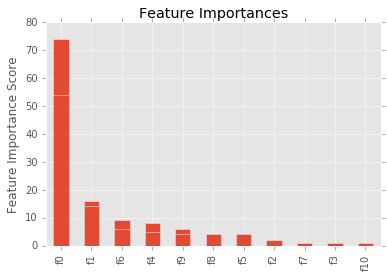

In [37]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.cross_validation import train_test_split

def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        dtrain = xgb.DMatrix(X,label=y)
        cvresult = xgb.cv(xgb_param,
                          dtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='error', # no accuracy
                          callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                                     xgb.callback.early_stop(early_stopping_rounds)]
                         )
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions)
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)
modelfit(xgb1, df[predictor_var], df[outcome_var])


#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=42)
modelfit(xgb1, X, y)

<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

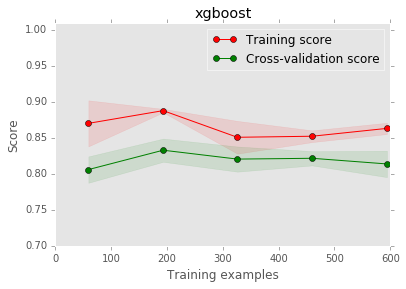

In [38]:
plot_learning_curve(xgb1, "xgboost", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [39]:
# now work on test data
test_df.apply(lambda x: x.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [40]:
test_df.drop(['Ticket','Cabin'],inplace=True, axis=1)

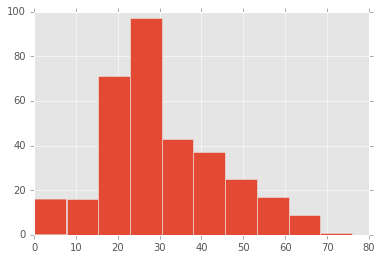

In [41]:
test_df.Age.hist()

In [42]:
test_df.Age.fillna(test_df.Age.median(), inplace=True)

In [43]:
test_df[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,S


In [44]:
test_df.Embarked = test_df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [45]:
mean_fare = test_df[test_df.Embarked==0]['Fare'].mean() ; mean_fare

28.230436431226767

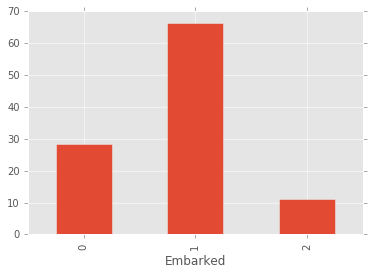

In [46]:
test_df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [47]:
test_df.Fare.fillna(mean_fare, inplace = True)

In [48]:
test_df['FamilySize'] = test_df.SibSp + test_df.Parch
test_df.drop(['SibSp','Parch'],axis=1, inplace=True)

In [49]:
test_df['Person'] = test_df[['Age','Sex']].apply(lambda x: 'child' if x[0]<16 else x[1], axis=1)
# first convert to str, then map
test_df.Person = test_df.Person.astype(str).map({'male':1,'female':0,'child':2})
test_df.drop(['Sex','Age'], axis=1, inplace = True)

In [50]:
test_df[:10]

,PassengerId,Pclass,Name,Fare,Embarked,FamilySize,Person
0,892,3,"Kelly, Mr. James",7.8292,2,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",7.0000,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",9.6875,2,0,1
3,895,3,"Wirz, Mr. Albert",8.6625,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",12.2875,0,2,0
5,897,3,"Svensson, Mr. Johan Cervin",9.2250,0,0,2
6,898,3,"Connolly, Miss. Kate",7.6292,2,0,0
7,899,2,"Caldwell, Mr. Albert Francis",29.0000,0,2,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",7.2292,1,0,0
9,901,3,"Davies, Mr. John Samuel",24.1500,0,2,1


In [51]:
# encoding, standarize
X_test_cat = ohe.transform(test_df[categorical])
X_test_non_cat = sc.transform(test_df[non_categorical])
X_test = hstack((X_test_non_cat, X_test_cat))

In [52]:
Y_pred = rf_model.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./submissions/rf5.csv', index=False)

In [53]:
# SVM1: .79426
# SVM2: .78469. use FamilySize instead of SibSp, Parch
# SVM3: .79426. Use both. no improvement
# SVM4: .79426, map sex, age to person
# xgb1, rf1 : not as good as svm1
# dt1,  .76077
# lr1: .76077, trees = 100, depth = 5
# rf2: .77512, n_estimator=300, maxdepth = 6
# rf3: .78469, n_estimator=300, maxdepth = 6, change from fit_transform to transform to generate X_test
# rf4: .79426, map sex, age to person
# rf5: .80861, use familysize instead of sibsp, parch